# Real world vehicle maneuver recognition using smartphone sensors and LSTM models

In [8]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats
from scipy.signal import savgol_filter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

from numpy.random import default_rng
import math

import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [9]:
np.random.seed(1896)
random.seed(1896)

## Loading the dataset
The dataset consists of 19 variables and the recording of three different people with different vehicles. Each driving maneuver was assigned a maneuver type, the route section, and road type as well as an unique maneuver ID. The smartphone sensor data includes datetime, acceleration on and rotation around three orthogonal axes, as well as GPS information such as longitude, latitude, altitude, accuracy and speed.

In [11]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01


# Data cleaning & preprocessing:

## Filtering

Real world data of smartphone sensors used to record driving behaviour will always be noisy due to the vehicle's own vibrations as well as road surface conditions and irregularities. The data from the smartphone sensors is noisy due to the vehicle's own vibrations and the bumps in the road. To reduce this noise, filtering can be applied. One method to smooth noisy data is the Savitzky-Golay filter. It applies a polynomial regression to windows of an arbitrary width.


One advantage of the Savitzky-Golay filter over methods such as a moving average is that high frequencies are not simply cut off, but are included in the calculation. This allows the filter to preserve important properties of the distribution such as relative maxima or minima.

In [12]:
snippet = df.iloc[400:900,:].copy()
snippet['filtered_accX'] = savgol_filter(snippet['accX'], 20, 6)

fig = go.Figure()

fig.add_trace(go.Scatter(x=snippet.datetime, 
                         y=snippet.accX, mode='lines'))

fig.add_trace(go.Scatter(x=snippet.datetime, 
                         y=snippet.filtered_accX, mode='lines'))
fig.show()


We will apply this filter to all variables of the accelerometer and gyroscope. In a more detailed investigation it would be possible to study the effect of using different polynomial orders for different variables.

In [13]:
vars_to_filter = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

for var in vars_to_filter:
    df[var] = savgol_filter(df[var], window_length=20, polyorder=6)

## Exploring the amount of recorded maneuver types

To examine how many individual driving maneuvers were recorded per maneuver type, the following plot can be considered. It turns out that some maneuvers, such as overtaking or crossing an intersection, occurred in too few cases overall. Therefore these maneuvers should be excluded. However, since the direct removal of corresponding time points would lead to breaks in the time series and thus additionally unnatural transitions from the remaining maneuvers to each other would arise, this is done only at a later point, after the execution of windowing.

In [14]:
unique_maneuvers = df.drop_duplicates(subset=['maneuverID','maneuverType'])['maneuverType'].value_counts()

fig = px.bar(x=unique_maneuvers.index, y=unique_maneuvers.values,
            title='Amount of maneuvers per type')

fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

## Windowing and Train-/Test-Splitting

Our goal is to create a model which can correctly identify driving maneuvers in unknown data of future driving recordings. Therefore, to train the model, we cannot simply use the individual maneuvers already assigned to their IDs, but have to use a sliding window to create training and testing cases.

In order to do that, we have to create two specific functions:
1. A windowing function that gets our data and returns windows with a specific amount of time steps and a speficifc step length between those windows in the shape of (cases, timesteps, variables).
2. A function to split the data into training and testing data before the windowing is applied. If we do not split training and testing data before using the windowing function, there will be data leakage because overlapping windows may end up in both partitions.

The 'create_dataset' function for the windowing is very simple since it only extracts the values for each time step and takes the mode of the label (our maneuver type) as the main label for the window.

For splitting the data into training and testing parts we create the 'sliced_train_test' function which can split the dataframe in a arbitrary number of partitions. Before we randomly select some of these in regard to our test size and apply the windowing function to them, we drop these partitions from our dataframe and create a scaler based on the remaining training data. 

With this approach, it can still happen occasionally that we create unnatural transitions between maneuvers that occurred before and after the part we cut out or that we break some maneuvers. However, the amount of it which depends on the number of splits we use will be negligible, as it is clearly more important that we have absolutely no data leakage. 

In [42]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(labels.mode()[0])
        #ys.append(stats.mode(labels)[0][0]) # removed because of DeprecationWarning
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def sliced_train_test(df, X_vars, y_var, splits, test_size, time_steps, stepsize):
    split_list = np.array_split(df, splits)
    
    rng = default_rng()
    numbers = rng.choice(splits, size=math.floor(splits*test_size), replace=False)

    df_full = df.copy()

    # remove test slices from dataframe so that we can create training data 
    # from everything thats left
    for num in numbers:
        df = df.drop(split_list[num].index)

    # scale based on training data
    scaler = RobustScaler()
    scaler = scaler.fit(df[X_vars].values)
    df.loc[:, X_vars] = scaler.transform(df[X_vars].to_numpy())

    # sample test splits based on random numbers
    X_test, y_test = [], []
    for num in numbers:
        split_idx = split_list[num].index
        
        extract = df_full.loc[split_idx,:]
        extract.loc[:, X_vars] = scaler.transform(extract[X_vars].to_numpy())
        
        X_slice, y_slice = create_dataset(extract[X_vars], extract[y_var], time_steps, stepsize)

        X_test.append(X_slice)
        y_test.append(y_slice)
    
    X_test, y_test = np.vstack(X_test), np.vstack(y_test)

    X_train, y_train = create_dataset(df[X_vars], df[y_var], time_steps, stepsize)
    
    return X_train, y_train, X_test, y_test

Now we can apply our functions. In order to avoid mixing the trips of the three test subjects within the windowing function and to ensure that different route segments of the subjects can appear in the training and test data sets, we apply the function individually. Our windows will have a length of 20 timesteps which is 10 seconds in our dataset and we will use a stepsize of 4 timesteps which equals 2 seconds. We then merge the data, with every window seperated and already in the right shape.

In [43]:
df_p1 = df.loc[df['person']=='P01',:]
df_p2 = df.loc[df['person']=='P02',:]
df_p3 = df.loc[df['person']=='P03',:]

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']
y_var = 'maneuverType'
splits = 40
test_size = 0.2
time_steps = 20
stepsize = 4

X_train1, y_train1, X_test1, y_test1 = sliced_train_test(df_p1, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train2, y_train2, X_test2, y_test2 = sliced_train_test(df_p2, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train3, y_train3, X_test3, y_test3 = sliced_train_test(df_p3, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train = np.vstack((X_train1, X_train2, X_train3))
y_train = np.vstack((y_train1, y_train2, y_train3))
X_test = np.vstack((X_test1, X_test2, X_test3))
y_test = np.vstack((y_test1, y_test2, y_test3))

## Removing rare maneuvers and undersampling the class with way too much samples

At the beginning we could already see that certain maneuvers occurred in a way too small amount of cases and that there is also an unbalanced distribution. Because of what we just did with the windowing, we can now drop those maneuvers without affecting others. But first lets check the distribution again.

In [44]:
np.unique(y_train, return_counts=True)

(array(['acceleration_from_standing', 'acceleration_lane',
        'continuous_driving', 'crossing_intersection',
        'crossing_roundabout', 'curve_left', 'curve_right',
        'deceleration_lane', 'overtaking', 'stationary',
        'targeted_braking', 'turn_left', 'turn_right'], dtype='<U26'),
 array([ 265,    6, 3358,   40,   63,  222,  246,   56,   24,  749,  418,
         158,  140]))

Below we will remove those rare maneuvers. In the case of the maneuvers 'stationary' and 'continuous_driving', which are present in too high a number of cases, we will apply undersampling and remove individual windows. For 'continuous_driving' we will can set the proportion of cases to drop.

In [45]:
drop_maneuvers = ['acceleration_lane', 'overtaking', 'deceleration_lane', 'crossing_roundabout', 'crossing_intersection']
maneuvers_to_drop_train = np.where(np.isin(y_train, drop_maneuvers))[0]
maneuvers_to_drop_test = np.where(np.isin(y_test, drop_maneuvers))[0]

stationary_to_drop_train = np.where(y_train == 'stationary')[0][::2] # every 2nd
stationary_to_drop_test = np.where(y_test == 'stationary')[0][::2] # every 2nd

cd_maneuvers_train = np.where(y_train == 'continuous_driving')[0]
cd_maneuvers_test = np.where(y_test == 'continuous_driving')[0]

proportion_to_drop = 0.9
cd_drop_train = random.sample(list(cd_maneuvers_train),
                               k=round(proportion_to_drop*len(cd_maneuvers_train)))
cd_drop_test = random.sample(list(cd_maneuvers_test),
                               k=round(proportion_to_drop*len(cd_maneuvers_test)))

to_drop_train = np.hstack((maneuvers_to_drop_train, cd_drop_train, stationary_to_drop_train))
to_drop_test = np.hstack((maneuvers_to_drop_test, cd_drop_test, stationary_to_drop_test))


#len(cd_maneuvers_train), amount_to_drop_train

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, len(to_drop_train), len(to_drop_test)

((5745, 20, 7), (5745, 1), (1327, 20, 7), (1327, 1), 3586, 799)

In [47]:
X_train = np.delete(X_train, to_drop_train, axis=0)
y_train = np.delete(y_train, to_drop_train)

X_test = np.delete(X_test, to_drop_test, axis=0)
y_test = np.delete(y_test, to_drop_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2159, 20, 7), (2159,), (528, 20, 7), (528,))

Let's have another look at the amount of windows in our new training and testing partitions. There will still be slight imbalance between our maneuver classes, but now the data set is much better suited for training and testing our model and since we are dealing with real world data it is fine not to synthetically bring the data to an absolute balanced ratio.

In [48]:
fig = go.Figure(data=[
    go.Bar(name='Test data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1]),
    go.Bar(name='Training data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1])
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

## Label encoding and final transformation

Now we have to create a label encoder so that we can extract the correct labels of the predictions later. The last step is to turn our training and testing data into the format of a PyTorch variable.

In [49]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

# Creating the model

## Defining the model architecture

Our next step is to define the architecture of the model. In the process, different network structures can be tested. The following structure we use here has proven to be promising:
The network is first composed of a multi-layer long short-term memory (LSTM) RNN with four stacked layers (n_layers) and 24 outputs to the fully-connected layer (n_hidden). Additionally we implement a dropout of 0.7, which is a very high value, but showed a positive effect on the generalizability of the model. The fully-connected layer consists of two relu layers with a dropout of 0.3 and a final linear layer that produces the output with the dimension of our classes.

In [50]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class maneuverModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=24, n_layers=4):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            batch_first = True, # Format
            dropout = 0.7
        )

        self.full_layer1 = nn.Linear(n_hidden, 64) # vorher 128
        self.dropout = nn.Dropout(0.3)
        self.full_layer2 = nn.Linear(64, 32)

        self.classifier = nn.Linear(32, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)

        out = hidden[-1]
        #out = F.relu(self.full_layer1(out))
        out = self.dropout(F.relu(self.full_layer1(out)))
        out = F.relu(self.full_layer2(out))
        out = self.classifier(out)
        return out

Using cpu device


What we also need are functions for the training and testing processes. For this purpose we use PyTorch's wrapper DataLoader, which allows easier access to samples.

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return [correct, test_loss]

## Initializing the model

At this point we can initialize the model. For this we set the number of features and classes and choose Adaptive Moment Estimation with a learning rate of 0.001 as optimization method. We also set CrossEntropyLoss as our loss function. 

In [64]:
n_features = X_train.shape[2]
n_classes = len(np.unique(y_train))
model     = maneuverModel(n_features, n_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

print(model)

maneuverModel(
  (lstm): LSTM(7, 24, num_layers=4, batch_first=True, dropout=0.7)
  (full_layer1): Linear(in_features=24, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (full_layer2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=8, bias=True)
)


## Training the model

After we initialize our dataloader, we can train the model.

In [65]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size)
test_dataloader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size)

epochs = 100

loss_list     = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, test_loss = test(test_dataloader, model, loss_fn)
    accuracy_list[epoch] = accuracy
    loss_list[epoch] = test_loss
print("Done!")

Epoch 1
-------------------------------
Test Error: Accuracy: 14.0%, Avg loss: 2.074590 

Epoch 2
-------------------------------
Test Error: Accuracy: 17.4%, Avg loss: 2.074377 

Epoch 3
-------------------------------
Test Error: Accuracy: 17.2%, Avg loss: 2.052966 

Epoch 4
-------------------------------
Test Error: Accuracy: 31.2%, Avg loss: 1.884203 

Epoch 5
-------------------------------
Test Error: Accuracy: 31.2%, Avg loss: 1.808145 

Epoch 6
-------------------------------
Test Error: Accuracy: 31.6%, Avg loss: 1.749391 

Epoch 7
-------------------------------
Test Error: Accuracy: 33.5%, Avg loss: 1.703499 

Epoch 8
-------------------------------
Test Error: Accuracy: 36.2%, Avg loss: 1.663616 

Epoch 9
-------------------------------
Test Error: Accuracy: 43.0%, Avg loss: 1.616874 

Epoch 10
-------------------------------
Test Error: Accuracy: 45.3%, Avg loss: 1.590460 

Epoch 11
-------------------------------
Test Error: Accuracy: 48.9%, Avg loss: 1.547915 

Epoch 12

By examining the evolution of validation accuracy and validation loss, we can see how good our training process works and whether we tend to some kind of over- or underfitting.

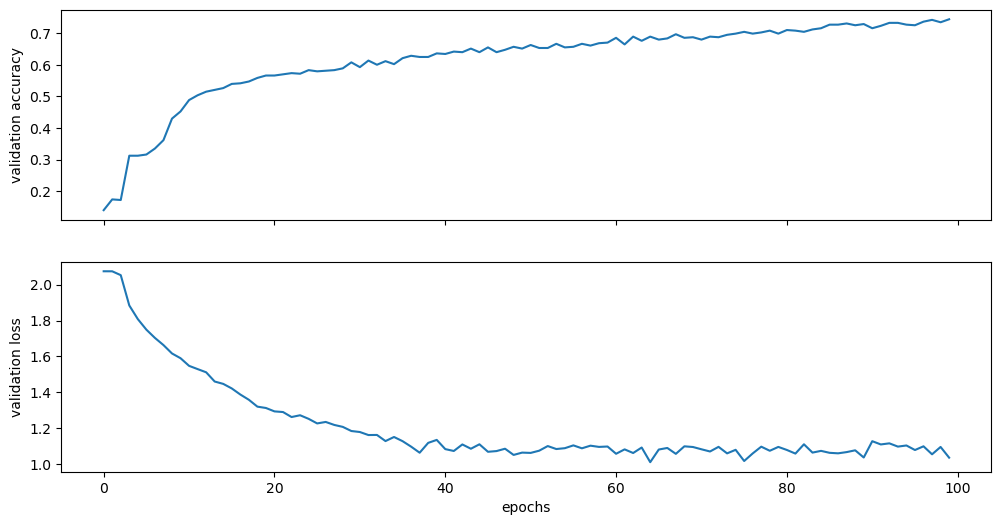

In [66]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

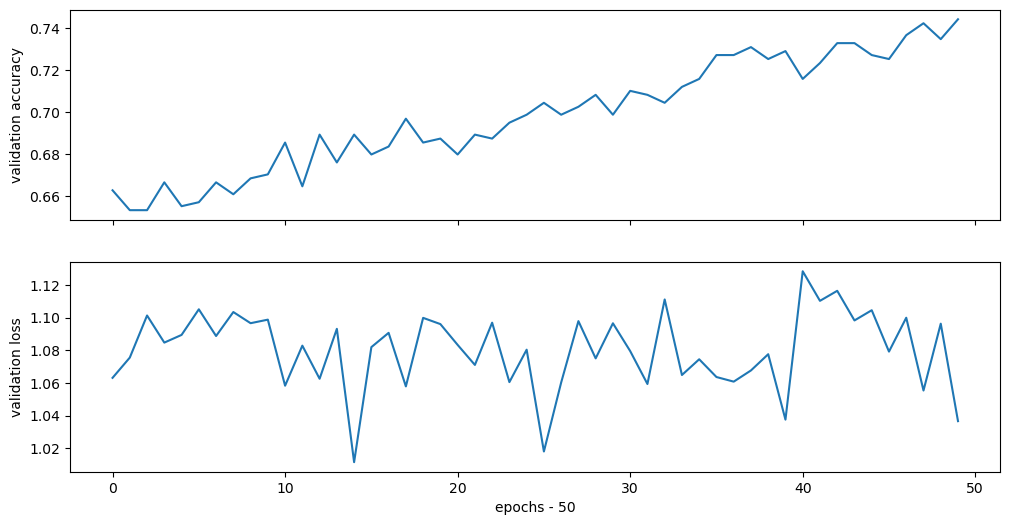

In [67]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list[50:])
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list[50:])
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs - 50");

## Evaluating the model

In order to evaluate the performance of our model, the predictions of the model for our test data can be compared with the actual values in the form of a confusion matrix. Since we have an unbalanced multi-class problem, and the color intensity takes all fields into account, the distribution should be inspected row by row.

In [68]:
y_pred = [pred.argmax() for pred in model(X_test)]

cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))
heatmap = go.Heatmap(z=cm, x=label_encoder.classes_, y=label_encoder.classes_, colorscale='Blues') # FEHLER IRGENDWO

# create the layout
layout = go.Layout(title='Confusion Matrix')

# create the figure
fig = go.Figure(data=[heatmap], layout=layout)

fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
fig.update_yaxes(title_text="Actual")
fig.update_xaxes(title_text="Predicted")

fig.layout.height = 900
fig.layout.width = 900

# show the figure
fig.show()

To get a better view of the precision of the model, we can slightly modify the Confusion Matrix and calculate row-wise relative values for the respective classes. In this way we can better understand for each actual class what proportion of which classes were predicted. With this the diagonal elements represent a measurement in the form of a class-specific precision metric.

Looking at these results, it is not only evident that certain maneuvers are already very well recognized. We also see that the misclassification of maneuvers with poorer precision is distributed among maneuvers that can logically overlap very strongly with these in practical execution.

In [69]:
def relativeCorrect(array):
    return array/sum(array)

def confusion_matrix_relative(y_test, y_pred):

    cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))

    cm_relative = np.apply_along_axis(relativeCorrect, 1, cm)
    heatmap = go.Heatmap(z=cm_relative, x=label_encoder.classes_, y=label_encoder.classes_,
                         colorscale='Blues')


    # create the layout
    layout = go.Layout(title='Confusion Matrix with rowwise relative values (relative predictions per actual class)')

    # create the figure
    fig = go.Figure(data=[heatmap], layout=layout)

    fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
    fig.update_yaxes(title_text="Actual")
    fig.update_xaxes(title_text="Predicted")

    fig.layout.height = 900
    fig.layout.width = 900
    # show the figure
    fig.show()

confusion_matrix_relative(y_test, y_pred)

In [58]:
torch.save(model.state_dict(), "model_04_10sec_filtered_2.pth")
print("Saved PyTorch Model State to model.pth")

model = maneuverModel(n_features, n_classes)
model.load_state_dict(torch.load("model_04_10sec_filtered.pth"))

Saved PyTorch Model State to model.pth


<All keys matched successfully>

This result can be used as a reference point for different approaches to improve maneuver recognition:

- A more in-depth optimization of the model could be executed to improve the overall performance.
- It could prove useful to develop a system that not only takes the most probable class as the prediction, but also considers the values of the second or third most probable class. This could be a way to better differentiate between maneuvers with share some properties.
- The categorical variable RoadType could also be included in the model. While in this project it was manually labeled, automated labeling for new trips would be easy to implement by using the GPS and public road data.